# Analysing Fit

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from data_load import load_data, pmumu, nll, lam_i, parabolic, nll_dm2, nll_theta

data, flux = load_data()

In [147]:
# rerunning parabolic minimum calcs, I will use the values given by the parabolic minimiser. 
dm2_0 = 1.4e-3
dm2_1 = 2.4e-3
dm2_2 = 3.4e-3
dm2_min_grid, nll_dm2_min, dm2_vals, nll_dm2_vals = parabolic(nll_dm2, dm2_0, dm2_1, dm2_2, tol = 1e-5)

print(dm2_min_grid, nll_dm2_min)

t0 = 0
t1 = 0.6
t2 = 1.2

theta_min_grid, nll_theta_min, theta_vals, nll_theta_vals = parabolic(nll_theta, t0, t1, t2, tol = 1e-3)

print(f'{theta_min_grid:.3f},{nll_theta_min:.3f}')

dm2_min = 0.002490764417552603
theta_min = 0.6759913232677012

0.002482874363087104 -84.1462289289104
0.676,-73.440


In [148]:


# estimating error by using curvature around minimum + using central finite difference for second deriv
def curv_method(f, min, step_size = 1e-3):
    """ 
    Calculating second derivative to then calculate sigma of the given function

    f = NLL function for 1 variable
    min = minimum value of parameter for given function

    Returns sigma
    """

    f0 = f(min - step_size)
    f1 = f(min)
    f2 = f(min + step_size)

    deriv2 = (f2 - 2 * f1 + f0)/step_size**2
    return np.sqrt(2/deriv2)

sigma_theta = curv_method(nll_theta, theta_min)
sigma_dm2 = curv_method(nll_dm2, dm2_min, step_size = 1e-5)

print(f'sigma theta: {sigma_theta:.3f}, sigma dm2: {sigma_dm2:.7f}')

print(f'Relative Error Theta: {sigma_theta/theta_min * 100:.3f}%')
print(f'Relative Error Dm2: {sigma_dm2/dm2_min * 100:.3f}%')

sigma theta: 0.013, sigma dm2: 0.0000154
Relative Error Theta: 1.893%
Relative Error Dm2: 0.619%


In [149]:
def deltaNLL(f, range_min, range_max, points=1000):
    """
    f = NLL
    range_min/max = scan range
    points =  number of grid points

    returns minimum parameter, alongside values where deltaNLL = +-1, and the associated errors
    """

    # range for scanning
    param_range = np.linspace(range_min, range_max, points)
    param_vals = np.array([f(x) for x in param_range])
    # minimum
    index_min = np.argmin(param_vals)
    param_min = param_range[index_min]
    nll_min  = param_vals[index_min]
    target = nll_min + 1.0  

    # upward scan
    i = index_min
    while i < points and param_vals[i] < target:
        i += 1
    if i == points:
        x_plus = param_range[-1]
    else:
        x1, y1 = param_range[i-1], param_vals[i-1]
        x2, y2 = param_range[i],   param_vals[i]
        x_plus = x1 + (target - y1) / (y2 - y1) * (x2 - x1)
    print(f'NLL upwards scan value:{param_vals[i]:.2f}')
    # downward scan
    i = index_min
    while i >= 0 and param_vals[i] < target:
        i -= 1

    if i < 0:
        x_minus = param_range[0]
    else:
        x1, y1 = param_range[i+1], param_vals[i+1]
        x2, y2 = param_range[i],   param_vals[i]
        x_minus = x1 + (target - y1) / (y2 - y1) * (x2 - x1)

    print(f'NLL downwards scan value:{param_vals[i]:.2f}')
    err_plus  = x_plus  - param_min
    err_minus = param_min  - x_minus

    return param_min, x_minus, x_plus, err_minus, err_plus

In [150]:
theta_best, theta_minus, theta_plus, dtheta_minus, dtheta_plus = deltaNLL(nll_theta, range_min = 0.0,range_max = 0.5*np.pi)

print(f'base NLL min val {nll_theta_min:.3f}')

print(f'Theta minimum: {theta_best:.3f}, theta value downwards scan: {theta_minus:.3f}, upwards scan: {theta_plus:.3f}')
print(f'change down: {dtheta_minus:.4f}, change up: {dtheta_plus:.4f}')

NLL upwards scan value:-72.39
NLL downwards scan value:-72.30
base NLL min val -73.440
Theta minimum: 0.676, theta value downwards scan: 0.663, upwards scan: 0.688
change down: 0.0133, change up: 0.0123


In [151]:
dm2_best, dm2_minus, dm2_plus, ddm2_minus, ddm2_plus = deltaNLL(nll_dm2, range_min = 1.0e-3,range_max = 5.0e-3)

print(f'base NLL min val {nll_dm2_min:.3f}')

print(f'dm2 minimum: {dm2_best:.3f}, dm2 value downwards scan: {dm2_minus:.5f}, upwards scan: {dm2_plus:.5f}')
print(f'change down: {ddm2_minus:.7f}, change up: {ddm2_plus:.7f}')

NLL upwards scan value:-83.44
NLL downwards scan value:-83.45
base NLL min val -84.146
dm2 minimum: 0.002, dm2 value downwards scan: 0.00248, upwards scan: 0.00251
change down: 0.0000137, change up: 0.0000175


In [ ]:
print(f'Error Width theta: {(dtheta_minus + dtheta_plus):.4f}')
print(f'Error Width dm2: {(ddm2_minus +ddm2_plus):.7f}')

print(f'Average Error theta: {(dtheta_minus - dtheta_plus)/2:.5f}')
print(f'Average Error dm2: {(ddm2_minus - ddm2_plus)/2:.7f}')

print(f'Relative Error Theta Minus: {dtheta_minus/theta_best * 100:.3f}%')
print(f'Relative Error Dm2 Minus: {ddm2_minus/dm2_best * 100:.3f}%')

print(f'Relative Error Theta Plus: {dtheta_plus/theta_best * 100:.3f}%')
print(f'Relative Error Dm2 Plus: {ddm2_plus/dm2_best * 100:.3f}%')

Error Width theta: 0.0256
Error Width dm2: 0.0000313
Average Error theta: 0.00050
Average Error dm2: -0.0000019
Relative Error Theta Minus: 1.966%
Relative Error Dm2 Minus: 0.551%
Relative Error Theta Plus: 1.817%
Relative Error Dm2 Plus: 0.703%


In [155]:
print(f'Average Relative Error Theta: {100*(dtheta_minus/theta_best + dtheta_plus/theta_best)/2:.3f}%')
print(f'Average Relative Error dm2: {100*(ddm2_minus/dm2_best + ddm2_plus/dm2_best)/2:.3f}%')

Average Relative Error Theta: 1.891%
Average Relative Error dm2: 0.627%


In [161]:
print(f'Error comparison ratio theta: {abs((0.5*(dtheta_minus+dtheta_plus))/sigma_theta - 1)*100}')
print(f'Error comparison ratio dm2: {abs((0.5*(ddm2_minus+ddm2_plus))/sigma_dm2 - 1)*100}')

Error comparison ratio theta: 0.05160687377713247
Error comparison ratio dm2: 1.4523284974731876


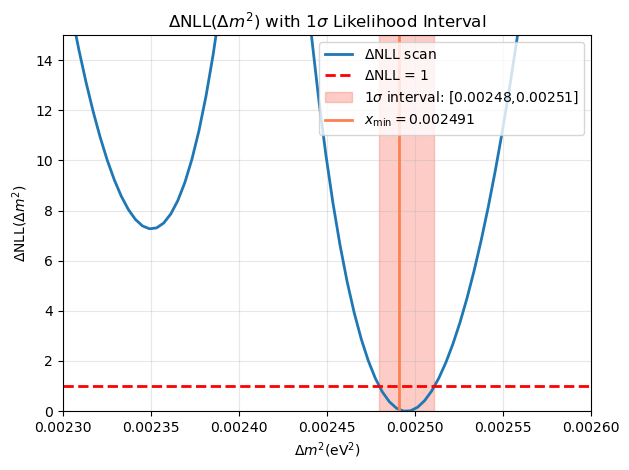

In [139]:
# build scan arrays again for plotting 
range_min = 1.0e-3
range_max = 5.0e-3
xs = np.linspace(range_min, range_max,1000)
nlls = np.array([nll_dm2(x) for x in xs])
dnll = nlls - np.min(nlls)

plt.plot(xs, dnll, linewidth=2, label='$\Delta$NLL scan')

# 1-sigma line
plt.axhline(1.0, linestyle='--', linewidth=2, label='$\Delta$NLL = 1', color = 'red')

# best fit and intersections
plt.axvspan(dm2_minus, dm2_plus, alpha=0.4, color='salmon', label=f'$1\sigma$ interval: [{dm2_minus:.5f},{dm2_plus:.5f}]')
plt.axvline(dm2_min, linestyle='-',  linewidth=2, label=f'$x_{{\min}}={dm2_min:.6f}$', color = 'coral')

plt.ylim(0,15)
plt.xlim(0.0023, 0.0026)
plt.title('$\Delta$NLL($\Delta m^2$) with $1\sigma$ Likelihood Interval')
plt.xlabel('$\Delta m^2$(eV$^2$)')
plt.ylabel('$\Delta$NLL($\Delta m^2$)')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

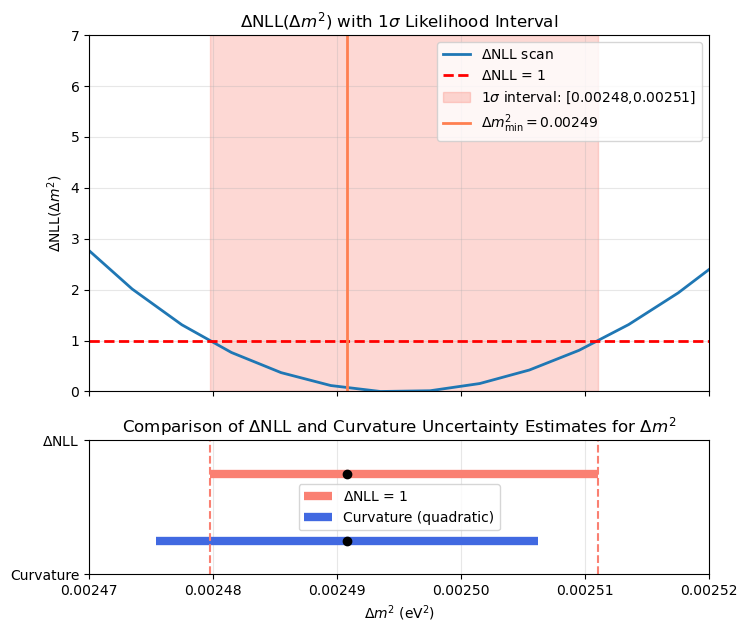

In [140]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,7), sharex=True, gridspec_kw={"height_ratios": [4, 1.5]})


ax1.plot(xs, dnll, linewidth=2, label='$\Delta$NLL scan')

ax1.axhline(1.0, linestyle='--', linewidth=2, label='$\Delta$NLL = 1', color='red')

ax1.axvspan(dm2_minus, dm2_plus, alpha=0.3, color='salmon', label=f'$1\sigma$ interval: [{dm2_minus:.5f},{dm2_plus:.5f}]')


ax1.axvline(dm2_min, linestyle='-', linewidth=2, label=f'$\Delta m^2_{{\min}}={dm2_min:.5f}$', color='coral')

ax1.set_ylim(0, 7)
ax1.set_xlim(0.00247, 0.00252)
ax1.set_ylabel('$\Delta$NLL($\Delta m^2$)')
ax1.set_title('$\Delta$NLL($\Delta m^2$) with $1\sigma$ Likelihood Interval')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)


ax2.hlines(y=1.05, xmin=dm2_minus, xmax=dm2_plus, linewidth=6, label='$\Delta$NLL = 1',color='salmon')

ax2.hlines( y=0.95, xmin=dm2_min - sigma_dm2, xmax=dm2_min + sigma_dm2, linewidth=6, 
           label='Curvature (quadratic)', color='royalblue')

ax2.axvline(dm2_minus, ls='--', color = 'salmon')
ax2.axvline(dm2_plus, ls='--', color = 'salmon')
ax2.plot(dm2_min, 1.05, 'ko')
ax2.plot(dm2_min, 0.95, 'ko')


ax2.set_yticks([0.9, 1.1])
ax2.set_yticklabels(['Curvature', '$\Delta$NLL'])
ax2.set_xlabel('$\Delta m^2$ (eV$^2$)')
ax2.set_title('Comparison of $\Delta$NLL and Curvature Uncertainty Estimates for $\Delta m^2$')
ax2.legend(loc='center')
ax2.grid(axis='x', alpha=0.3)
plt.show()

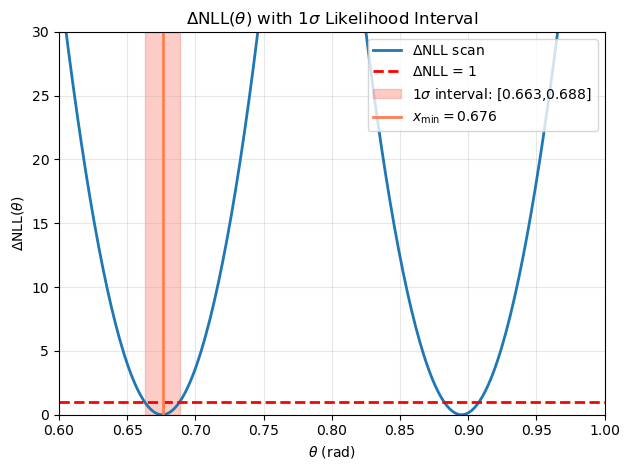

In [142]:
# build scan arrays again for plotting 
range_min = 0.0
range_max = 0.5*np.pi
xs = np.linspace(range_min, range_max,1000)
nlls = np.array([nll_theta(x) for x in xs])
dnll = nlls - np.min(nlls)

plt.plot(xs, dnll, linewidth=2, label='$\Delta$NLL scan')

# 1-sigma line
plt.axhline(1.0, linestyle='--', linewidth=2, label='$\Delta$NLL = 1', color = 'red')

# best fit and intersections
plt.axvspan(theta_minus, theta_plus, alpha=0.4, color='salmon', label=f'$1\sigma$ interval: [{theta_minus:.3f},{theta_plus:.3f}]')
plt.axvline(theta_min, linestyle='-',  linewidth=2, label=f'$x_{{\min}}={theta_min:.3f}$', color = 'coral')

plt.ylim(0,30)
plt.xlim(0.6, 1)
plt.title('$\Delta$NLL($\\theta$) with $1\sigma$ Likelihood Interval')
plt.xlabel('$\\theta$ (rad)')
plt.ylabel('$\Delta$NLL($\\theta$)')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

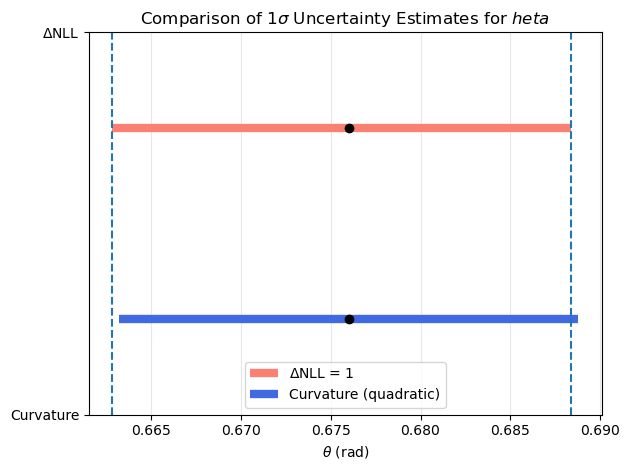

In [143]:

# likelihood interval
plt.hlines(y=1.05, xmin = theta_minus, xmax=theta_plus, linewidth=6, label='$\Delta$NLL = 1', color = 'salmon')

# curvature interval
plt.hlines( y=0.95,xmin=theta_min - sigma_theta, xmax=theta_min + sigma_theta,linewidth=6,label='Curvature (quadratic)', color = 'royalblue')
plt.axvline(theta_minus, ls='--')
plt.axvline(theta_plus, ls='--')
# best fit 
plt.plot(theta_min, 1.05, 'ko')
plt.plot(theta_min, 0.95, 'ko')

plt.yticks([0.9, 1.1], ['Curvature', '$\Delta$NLL'])
plt.xlabel('$\\theta$ (rad)')
plt.title('Comparison of $1\sigma$ Uncertainty Estimates for $\theta$')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

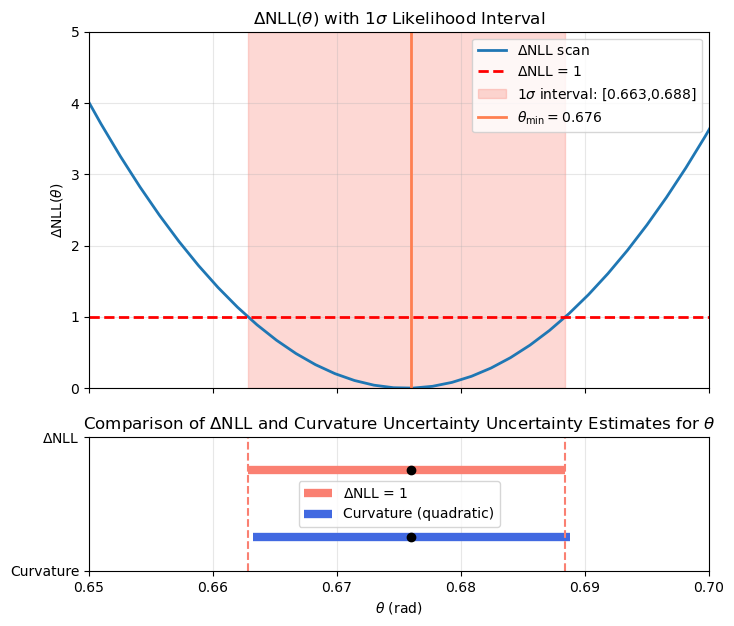

In [144]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,7), sharex=True, gridspec_kw={"height_ratios": [4, 1.5]})


ax1.plot(xs, dnll, linewidth=2, label='$\Delta$NLL scan')

ax1.axhline(1.0, linestyle='--', linewidth=2, label='$\Delta$NLL = 1', color='red')

ax1.axvspan(theta_minus, theta_plus, alpha=0.3, color='salmon', label=f'$1\sigma$ interval: [{theta_minus:.3f},{theta_plus:.3f}]')


ax1.axvline(theta_min, linestyle='-', linewidth=2, label=f'$\\theta_{{\min}}={theta_min:.3f}$', color='coral')

ax1.set_ylim(0, 5)
ax1.set_xlim(0.6, 1)
ax1.set_ylabel('$\Delta$NLL($\\theta$)')
ax1.set_title('$\Delta$NLL($\\theta$) with $1\sigma$ Likelihood Interval')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)


ax2.hlines(y=1.05, xmin=theta_minus, xmax=theta_plus, linewidth=6, label='$\Delta$NLL = 1',color='salmon')

ax2.hlines( y=0.95, xmin=theta_min - sigma_theta, xmax=theta_min + sigma_theta, linewidth=6, 
           label='Curvature (quadratic)', color='royalblue')

ax2.axvline(theta_minus, ls='--', color = 'salmon')
ax2.axvline(theta_plus, ls='--', color = 'salmon')
ax2.plot(theta_min, 1.05, 'ko')
ax2.plot(theta_min, 0.95, 'ko')
ax2.set_xlim(0.65, 0.7)

ax2.set_yticks([0.9, 1.1])
ax2.set_yticklabels(['Curvature', '$\Delta$NLL'])
ax2.set_xlabel('$\\theta$ (rad)')
ax2.set_title('Comparison of $\Delta$NLL and Curvature Uncertainty Uncertainty Estimates for $\\theta$')
ax2.legend(loc='center')
ax2.grid(axis='x', alpha=0.3)
plt.show()

# Comparison

# Curvature/Parabolic Method

For the curvature method it was sooooo easy to implement compared to the $\Delta NLL$ method.

Primarily what we do there is:

$$
NLL(x) \approx NLL_{min} + \frac{1}{2}(x-x_{min})^2NLL_{min}
$$

We estimate the value of the NLL at the minimum, calculate the second derivative and then use 

$$
\sigma = \sqrt{\frac{2}{NLL_{min}}}
$$

It produces a single symmetric error and is good to use if the NLL is quadratic as then it agrees well with the $\Delta NLL = 1$. I think we could also use it for error estimation via matrices for multivariable fitting.

However (and very unfortunately) our NLL is not a perfect quadratic and has visible asymmetry (seen in earlier task). This method assumes local quadratic behaviour so it's only an approximation, and also won't give us the true asymmetric errors that we should see.

Another issue is that it's step size dependent. Since we know that our parameters are to 1 d.p or 3 d.p ($\theta$ and $\Delta m^2$ respectively) then we can adjust our step size for each error approximation, but if the expected value is unknown or the step size is otherwise chosen badly, this means that it give out a very incorrect value

# $\Delta NLL = 1$ Method

This method drove me crazy, it was finnicky to code - did not have a good time. But it just simply outclasses the curvature approximation.

It uses the full shape of the NLL and gives asymmetric errors. It also naturally responds well to boundaries as it can still see the correct allowed range. 

The method used is simply to allow a range of values, plug in the nll, and then iterate through the code until $\Delta NLL = 1$. Writing it out now it makes me feel silly that it took me so long... Regardless! Due to various maths that will probably bore you, the forumlation of the NLL, 2lnX, means that upwards and downward scan values for $\Delta NLL = 1$ return $1\sigma$.

This code is taxing computationally, so for larger data sets it could quickly become an issue. The scan range must also be sensible so that $\Delta NLL = 1$ can be reached.

If the NLL is close enough to parabolic near the minimum, there are enough data points and the best/minimum value is inside the allowed range then both methods will work well

# Brief Results Discussion

curvature:
sigma theta: 0.012768479946578124, sigma dm2: 1.0784967348866248e-05

NLL:
average sigma value theta: 0.01276994380007751
average sigma value dm2: 1.5791473522138626e-05

In terms of the returned values, they essentially agree which does suggest that overall the curvature is a good apporximation but we can also see that the dm2 values differ by 5e-6. This isn't terrible, but it highlights were the curvature approximation can fail when only considering the local minimum, as opposed to the whole curve. 

The parabolic minimiser may have guessed incorrectly as to where the minimum NLL for $\Delta m^2$ was as the $\Delta NLL$ code is stating it's actually lower. I'm more inclined to believe the global $\Delta NLL$ scan than the parabolic approximation using local minima.